In [6]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
from ultralytics import YOLO  
import torch
from tqdm import tqdm
import time



In [7]:
def iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the intersection area
    x_inter = max(x1, x2)
    y_inter = max(y1, y2)
    w_inter = max(0, min(x1 + w1, x2 + w2) - x_inter)
    h_inter = max(0, min(y1 + h1, y2 + h2) - y_inter)

    intersection = w_inter * h_inter

    # Calculate the area of both bounding boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate the union area
    union = area1 + area2 - intersection

    return intersection / union


In [8]:
def load_ground_truths(labels_folder):
    """Load ground truth bounding boxes from label txt files, ignoring extra mask values."""
    ground_truths = []
    for label_file in os.listdir(labels_folder):
        if label_file.endswith(".txt"):
            label_path = os.path.join(labels_folder, label_file)
            boxes = []
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    # Only take the first 4 values (x_center, y_center, width, height)
                    try:
                        x_center, y_center, width, height = map(float, parts[1:5])  # Grab first 4 values
                        boxes.append([x_center, y_center, width, height])
                    except ValueError:
                        continue  # Skip any line with invalid data or extra parts
            ground_truths.append(boxes)
    return ground_truths

In [9]:
def load_images(images_folder):
    """Load images from the images folder."""
    images = []
    for image_file in os.listdir(images_folder):
        if image_file.endswith(('.jpg', '.png')):
            img_path = os.path.join(images_folder, image_file)
            img = cv2.imread(img_path)
            images.append(img)
    return images

In [19]:
def evaluate_model(yolo_model, images, ground_truths, thresholds=np.linspace(0, 1, 11), imgsz=704, device='cpu'):
    """Evaluate model and calculate TP and FP at different confidence thresholds."""
    tps = defaultdict(int)
    fps = defaultdict(int)
    fns = defaultdict(int)

    total_images = len(images)
    total_thresholds = len(thresholds)
    
    # Create a progress bar with tqdm
    with tqdm(total=total_images * total_thresholds, desc="Evaluating", unit="image") as pbar:
        for img, gt_boxes in zip(images, ground_truths):
            # Run the YOLO model prediction for each threshold separately
            for threshold in thresholds:
                start_time = time.time()  # Track start time for each evaluation
                
                # Get predictions from the YOLO model at the current confidence threshold
                results = yolo_model(img, imgsz=imgsz, task="segment", conf=threshold, device=device)

                # The results are a list, so we need to access the first element
                result = results[0] if isinstance(results, list) else results

                # Extract the bounding boxes and confidences from result.boxes
                boxes = result.boxes
                confidences = boxes.conf  # Confidence values
                bboxes = boxes.xywh  # Bounding box coordinates (x_center, y_center, width, height)

                tp, fp, fn = 0, 0, 0
                matched_gt = set()  # To track ground truths already matched

                # Iterate over the predicted boxes
                for bbox, confidence in zip(bboxes, confidences):
                    if confidence < threshold:
                        continue

                    # Convert from xywh to xyxy if needed for comparison with ground truth
                    pred_box = bbox.tolist()  # Convert to a regular list
                    x_center, y_center, width, height = pred_box
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    pred_box = [x_min, y_min, x_max, y_max]

                    # Compare with ground truth
                    matched = False
                    for i, gt_box in enumerate(gt_boxes):
                        if i not in matched_gt and iou(pred_box, gt_box) > 0.7:
                            tp += 1
                            matched_gt.add(i)
                            matched = True
                            break

                    if not matched:
                        fp += 1

                fn = len(gt_boxes) - len(matched_gt)
                tps[threshold] += tp
                fps[threshold] += fp
                fns[threshold] += fn

                # Update progress bar and add elapsed time
                elapsed_time = time.time() - start_time
                pbar.set_postfix(estimate=f"{elapsed_time:.2f}s/image")
                pbar.update(1)

    return tps, fps, fns

In [ ]:
if __name__ == "__main__":
    # Load your images and ground truth labels
    images_folder = 'images'
    labels_folder = 'labels'

    images = load_images(images_folder)
    ground_truths = load_ground_truths(labels_folder)

    yolo_model = YOLO('../model_weights/yolo_model_weights.pt')  # Load your YOLO instance segmentation model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    yolo_model.to(device)

    # Evaluate the model and calculate TP/FP at different thresholds
    tps, fps, fns = evaluate_model(yolo_model, images, ground_truths)

In [22]:
def plot_roc_curve(tps, fps, fns, thresholds):
    """Plot the ROC curve based on TP, FP, FN counts at different thresholds."""
    fpr = []  # False Positive Rate
    tpr = []  # True Positive Rate

    total_gt_boxes = sum(fns.values())  # Assuming fns contains counts of false negatives

    for threshold in thresholds:
        tp = tps.get(threshold, 0)
        fp = fps.get(threshold, 0)
        fn = fns.get(threshold, 0)

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fpr.append(fp / (fp + total_gt_boxes) if (fp + total_gt_boxes) > 0 else 0)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
print(tps)

print(fps)

print(fns)

defaultdict(<class 'int'>, {np.float64(0.0): 0, np.float64(0.1): 0, np.float64(0.2): 0, np.float64(0.30000000000000004): 0, np.float64(0.4): 0, np.float64(0.5): 0, np.float64(0.6000000000000001): 0, np.float64(0.7000000000000001): 0, np.float64(0.8): 0, np.float64(0.9): 0, np.float64(1.0): 0})
defaultdict(<class 'int'>, {np.float64(0.0): 645300, np.float64(0.1): 17687, np.float64(0.2): 13040, np.float64(0.30000000000000004): 10465, np.float64(0.4): 8497, np.float64(0.5): 6650, np.float64(0.6000000000000001): 4776, np.float64(0.7000000000000001): 2763, np.float64(0.8): 950, np.float64(0.9): 40, np.float64(1.0): 0})
defaultdict(<class 'int'>, {np.float64(0.0): 7474, np.float64(0.1): 7474, np.float64(0.2): 7474, np.float64(0.30000000000000004): 7474, np.float64(0.4): 7474, np.float64(0.5): 7474, np.float64(0.6000000000000001): 7474, np.float64(0.7000000000000001): 7474, np.float64(0.8): 7474, np.float64(0.9): 7474, np.float64(1.0): 7474})


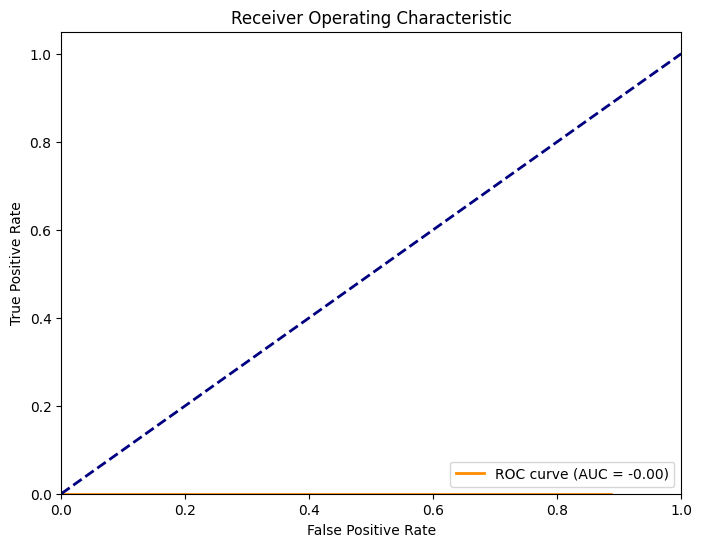

In [30]:
plot_roc_curve(tps, fps, fns, np.linspace(0, 1, 11))